# Dynamical Decoupling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qctrl
import qctrlopencontrols as qoc
import qctrlvisualizer as qv

In [2]:
plt.style.use(qv.get_qctrl_style())

qctrl = qctrl.Qctrl(
    organization="qiqb"
)

$$
H = \delta \frac{\sigma_z}{2} + I(t) \frac{\sigma_x}{2} + Q(t) \frac{\sigma_y}{2}
$$

In [3]:
T = 1e-6
times = np.linspace(0, T, 500)

delta = 2 * np.pi * 0.1e6

maximum_rabi_rate = 2 * np.pi * 20 * 1e6
maximum_detuning_rate = 2 * np.pi * 1000 * 1e6
minimum_segment_duration = 2 * 1e-9

state_rand = qt.rand_ket_haar(2, seed=0)
state_plus = (qt.basis(2, 0) + qt.basis(2, 1)).unit()

In [4]:
SE = "SE"
CP = "CP"
CPMG = "CPMG"
UDD = "UDD"
QDD = "QDD"

sequences = {
    SE: qoc.new_spin_echo_sequence(
        duration=T,
        name=SE,
    ),
    CP: qoc.new_carr_purcell_sequence(
        duration=T,
        offset_count=4,
        name=CP,
    ),
    CPMG: qoc.new_cpmg_sequence(
        duration=T,
        offset_count=4,
        name=CPMG,
    ),
    UDD: qoc.new_uhrig_sequence(
        duration=T,
        offset_count=4,
        name=UDD,
    ),
    QDD: qoc.new_quadratic_sequence(
        duration=T,
        inner_offset_count=2,
        outer_offset_count=2,
        name=QDD,
    ),
}

controls = {
    name: qoc.convert_dds_to_driven_control(
        sequence,
        maximum_rabi_rate=maximum_rabi_rate,
        maximum_detuning_rate=maximum_detuning_rate,
        minimum_segment_duration=minimum_segment_duration,
        name=name,
    )
    for name, sequence in sequences.items()
}

In [35]:
def plot_sequence(dd: str):
    sequence = sequences[dd]
    qv.plot_sequences(sequence.export())


def plot_control(dd: str):
    control = controls[dd]
    qv.plot_controls(
        {
            dd: {
                "durations": control.durations,
                "values": control.amplitude_x + 1j * control.amplitude_y,
            }
        },
        polar=True,
    )


def calculate_unitaries(dd: str, detuning=0) -> np.ndarray:
    control = controls[dd]
    graph = qctrl.create_graph()

    I = graph.pwc(
        values=control.amplitude_x,
        durations=control.durations,
    )

    Q = graph.pwc(
        values=control.amplitude_y,
        durations=control.durations,
    )

    H_sys = 0.5 * detuning * qt.sigmaz()
    H_ctrl = 0.5 * I * qt.sigmax() + 0.5 * Q * qt.sigmay()

    hamiltonian = H_sys + H_ctrl

    graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian,
        sample_times=times,
        name="unitaries",
    )

    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitaries"],
        
    )

    return result.output["unitaries"]["value"]


def draw_bloch_trajectory(unitary: np.ndarray, initial_state):
    initial_state = qt.Qobj(initial_state).full()
    states = unitary @ initial_state
    qv.display_bloch_sphere(states.squeeze()[::2])


def min_fidelity(unitaries: np.ndarray, repetitions=1000):
    U = qt.Qobj(unitaries[-1])
    fidelities = []
    for _ in range(repetitions):
        initial_state = qt.rand_ket_haar(2)
        final_state = U * initial_state
        fidelity = qt.fidelity(initial_state, final_state)
        fidelities.append(fidelity)    
    return np.min(fidelities)

# Spin Echo

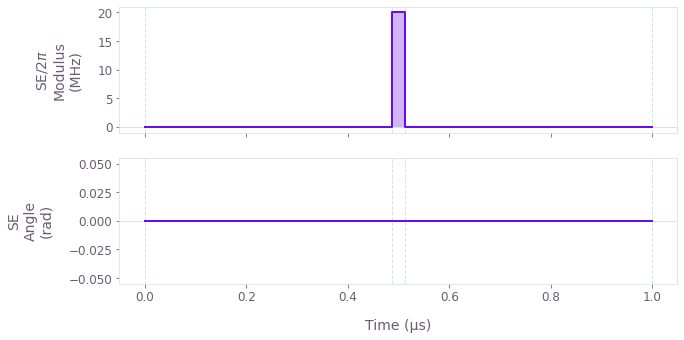

In [6]:
plot_control(SE)

In [7]:
U_se = calculate_unitaries(SE, delta)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1823027") has completed.


In [32]:
draw_bloch_trajectory(U_se, state_plus)

<IPython.core.display.Javascript object>

In [9]:
draw_bloch_trajectory(U_se, state_rand)

<IPython.core.display.Javascript object>

In [36]:
min_fidelity(U_se)

0.0019609587587460712

# Carr-Purcell

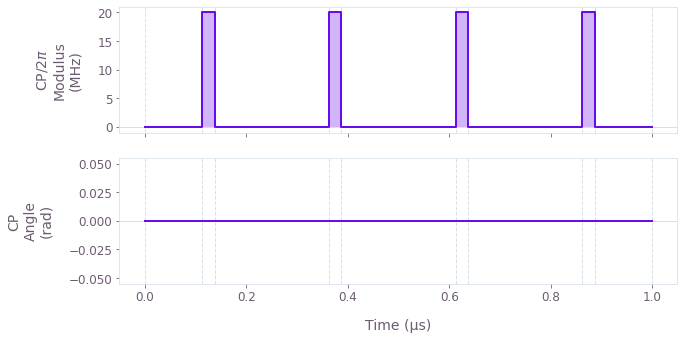

In [10]:
plot_control(CP)

In [11]:
U_cp = calculate_unitaries(CP, delta)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1823028") has completed.


In [12]:
draw_bloch_trajectory(U_cp, state_plus)

<IPython.core.display.Javascript object>

In [38]:
draw_bloch_trajectory(U_cp, state_rand)

<IPython.core.display.Javascript object>

In [39]:
min_fidelity(U_cp)

0.999998888665026

# CPMG

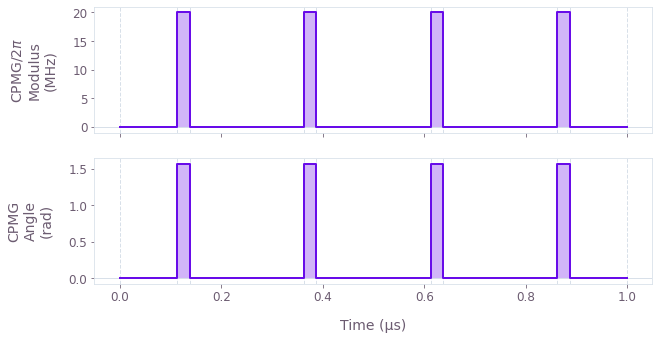

In [14]:
plot_control(CPMG)

In [15]:
U_cpmg = calculate_unitaries(CPMG, delta)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1823029") has completed.


In [16]:
draw_bloch_trajectory(U_cpmg, state_plus)

<IPython.core.display.Javascript object>

In [17]:
draw_bloch_trajectory(U_cpmg, state_rand)

<IPython.core.display.Javascript object>

In [40]:
min_fidelity(U_cpmg)

0.9999988886620658

# UDD

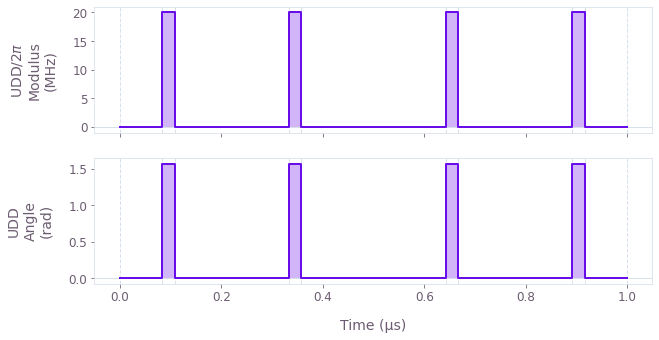

In [18]:
plot_control(UDD)

In [19]:
U_udd = calculate_unitaries(UDD, delta)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1823030") has completed.


In [20]:
draw_bloch_trajectory(U_udd, state_plus)

<IPython.core.display.Javascript object>

In [21]:
draw_bloch_trajectory(U_udd, state_rand)

<IPython.core.display.Javascript object>

In [41]:
min_fidelity(U_udd)

0.9999988890425202

# QDD

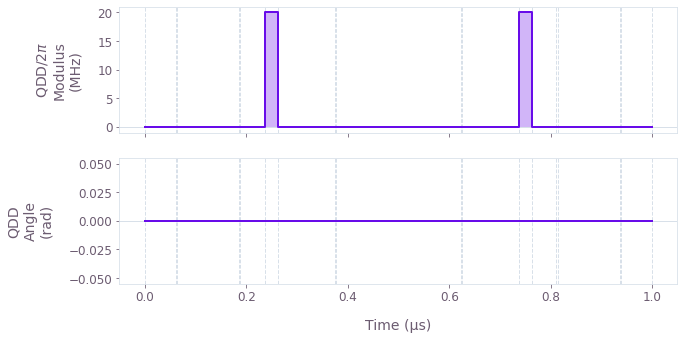

In [22]:
plot_control(QDD)

In [23]:
U_qdd = calculate_unitaries(QDD, delta)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1823031") has completed.


In [24]:
draw_bloch_trajectory(U_qdd, state_plus)

<IPython.core.display.Javascript object>

In [25]:
draw_bloch_trajectory(U_qdd, state_rand)

<IPython.core.display.Javascript object>

In [42]:
min_fidelity(U_qdd)

0.9999988363655004